<a href="https://colab.research.google.com/github/joonheeCho/Artificial-Intelligence-Basic-Course/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%EA%B8%B0%EC%B4%88%EA%B3%BC%EC%A0%95_Day5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**< Variational Autoencoder 실습>**

1) Define Hyper-parameters / Set configuration

In [1]:
import torch
import os

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Directroy Path Configuration (샘플링된 데이터와, reconstructed된 데이터를 모두 저장)
sample_dir = './results'
if not os.path.exists(sample_dir):
   os.makedirs(sample_dir)

# Set Hyper-parameters
image_size = 28*28
h_dim = 400
z_dim = 20

num_epochs = 20
batch_size = 128
learning_rate = 1e-3

2) load data

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

# test_data is not taken from datasets. (It will be reconstructed)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



3) define dataloader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

#Test_loader is not used as well

In [6]:
# To check data_loader form
image, label = next(iter(train_loader))
print(image.size())# [Batch, Channel, Height, Width]
print(label)

torch.Size([128, 1, 28, 28])
tensor([0, 9, 4, 3, 8, 7, 6, 9, 2, 0, 7, 9, 5, 6, 8, 8, 6, 4, 4, 5, 7, 2, 1, 2,
        7, 3, 0, 6, 4, 9, 1, 4, 6, 1, 0, 7, 8, 8, 8, 0, 5, 5, 9, 6, 6, 8, 1, 4,
        4, 6, 5, 3, 2, 8, 8, 4, 0, 2, 0, 4, 3, 4, 3, 0, 6, 9, 4, 3, 7, 7, 2, 9,
        5, 1, 5, 3, 3, 3, 9, 7, 4, 5, 5, 1, 2, 9, 0, 8, 0, 8, 1, 0, 1, 0, 6, 5,
        2, 6, 9, 4, 8, 5, 1, 2, 2, 5, 9, 1, 1, 4, 0, 9, 0, 3, 3, 0, 8, 7, 6, 6,
        1, 7, 6, 8, 9, 9, 3, 8])


4) define model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class VAE(nn.Module):
  def __init__(self, image_size=image_size, h_dim=h_dim, z_dim=z_dim):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(image_size, h_dim)
    self.fc2 = nn.Linear(h_dim, z_dim)  # 평균
    self.fc3 = nn.Linear(h_dim, z_dim)  # 분산   # 인코더 부분
    self.fc4 = nn.Linear(z_dim, h_dim)        
    self.fc5 = nn.Linear(h_dim, image_size)      # 디코더 부분

  
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    return self.fc2(h), self.fc3(h)
    # VAE는 input 데이터를 statistical distribution에 관련된 값인 mean, variance로 분류하고, 이 값을 latent space에 넣는다. 

  def reparameterizer(self, mu, log_var):
    std = torch.exp(log_var/2)
    eps = torch.randn_like(std)
    return mu + eps * std   
    # 그리고 이 값을 통해 z = z_mean + exp(z_log_variance) * epsilon 형태의 z를 샘플 포인트로 생성한다. (샘플링 과정)

  def decoder(self, z):
    h = F.relu(self.fc4(z))
    return F.sigmoid(self.fc5(h))

  def forward(self, x):
    mu, log_var = self.encoder(x)  
    z = self.reparameterizer(mu, log_var)
    x_reconstructed = self.decoder(z)

    return x_reconstructed, mu, log_var

model = VAE().to(device)

5) Set Loss & Optimizer

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss ; will be defined in training step as a combination of Reconstruction Loss and Regularization Loss

6) Train / Test

In [10]:
from torchvision.utils import save_image

In [11]:
for epoch in range(num_epochs):
  for i, (x, _) in enumerate(train_loader):   # label을 안받기에 이미지 부분만 X로 받음
    # Feed Forward
    x = x.to(device).view(-1, image_size)     # VAE 입력으로 넣기 위해 shape를 맞춤
    x_reconstructed, mu, log_var = model(x)

    # Compute total loss
    reconst_loss = F.binary_cross_entropy(x_reconstructed, x, size_average=False)
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Get Loss, Compute Gradient, Update Parameters
    loss = reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print Loss
    if (i+1) % 100 == 0:
      print("Epoch[{}/{}], Step[{}/{}], Reconstruction Loss: {:.4f}, KL Divergence: {:.4f}".format(epoch+1, num_epochs, i+1, len(train_loader), reconst_loss.item(), kl_div.item()))

  # Save Generated Image and Recond
  with torch.no_grad():
    # Save the sample images (for comparison)
    z = torch.randn(batch_size, z_dim).to(device)   # 임의의 분포 z 
    out = model.decoder(z).view(-1, 1, 28, 28)
    save_image(out, os.path.join(sample_dir, 'samepled-{}.png'.format(epoch+1)))

    # Save the reconstructed images
    out, _, _ = model(x)
    x_concat = torch.cat([x.view(-1,1,28,28), out.view(-1,1,28,28)], dim=3)
    save_image(x_concat, os.path.join(sample_dir, 'reconstructed-{}.png'.format(epoch+1)))


# Save Model at the last epoch
torch.save(model.state_dict(), 'my_VAE_model.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Step[100/469], Reconstruction Loss: 22608.5664, KL Divergence: 1158.3241
Epoch[1/20], Step[200/469], Reconstruction Loss: 17351.1348, KL Divergence: 2005.2085
Epoch[1/20], Step[300/469], Reconstruction Loss: 15569.1953, KL Divergence: 2255.9094
Epoch[1/20], Step[400/469], Reconstruction Loss: 14460.1641, KL Divergence: 2550.5862
Epoch[2/20], Step[100/469], Reconstruction Loss: 13100.6152, KL Divergence: 2826.4324
Epoch[2/20], Step[200/469], Reconstruction Loss: 12178.2646, KL Divergence: 2821.9719
Epoch[2/20], Step[300/469], Reconstruction Loss: 12839.0332, KL Divergence: 2893.6621
Epoch[2/20], Step[400/469], Reconstruction Loss: 11902.6562, KL Divergence: 2923.9604
Epoch[3/20], Step[100/469], Reconstruction Loss: 11226.0605, KL Divergence: 2989.0146
Epoch[3/20], Step[200/469], Reconstruction Loss: 11764.6035, KL Divergence: 3135.3467
Epoch[3/20], Step[300/469], Reconstruction Loss: 11476.2676, KL Divergence: 3088.8167
Epoch[3/20], Step[400/469], Reconstruction Loss: 11783

**< Generative Adversarial networks 실습>**

1) 학습에 필요한 파라미터 설정

In [12]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# 하이퍼파라미터
EPOCHS = 10
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


2) 학습에 필요한 dataset 로딩

In [14]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



3) 생성자 정의

In [15]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

4) 판별자 정의

In [16]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

5) Set Loss & Optimizer

In [17]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

6) Train & Test

In [19]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch+1, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [1/10], d_loss: 0.0189, g_loss: 4.8377, D(x): 1.00, D(G(z)): 0.02
Epoch [2/10], d_loss: 0.0176, g_loss: 5.3818, D(x): 1.00, D(G(z)): 0.01
Epoch [3/10], d_loss: 0.1346, g_loss: 6.3958, D(x): 0.95, D(G(z)): 0.02
Epoch [4/10], d_loss: 0.2389, g_loss: 2.9254, D(x): 0.92, D(G(z)): 0.07
Epoch [5/10], d_loss: 0.2712, g_loss: 4.1315, D(x): 0.92, D(G(z)): 0.05
Epoch [6/10], d_loss: 0.1351, g_loss: 5.1626, D(x): 0.97, D(G(z)): 0.05
Epoch [7/10], d_loss: 0.4169, g_loss: 4.6416, D(x): 0.90, D(G(z)): 0.03
Epoch [8/10], d_loss: 0.2939, g_loss: 3.2989, D(x): 0.96, D(G(z)): 0.11
Epoch [9/10], d_loss: 0.2534, g_loss: 4.8115, D(x): 0.92, D(G(z)): 0.06
Epoch [10/10], d_loss: 0.2663, g_loss: 5.3686, D(x): 0.93, D(G(z)): 0.07


7) 생성자의 결과물 확인

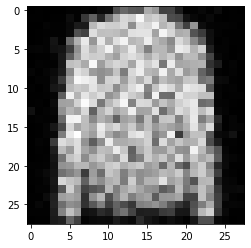

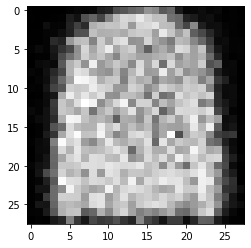

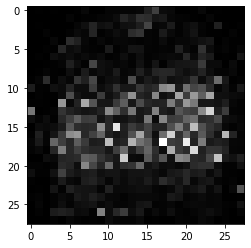

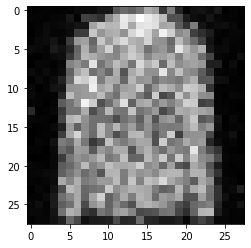

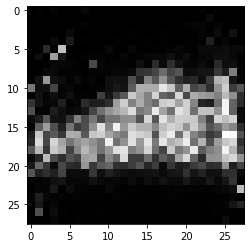

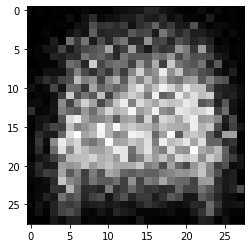

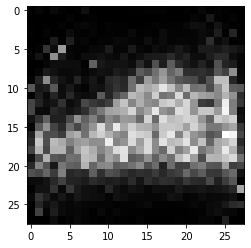

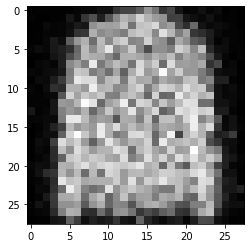

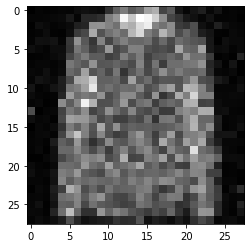

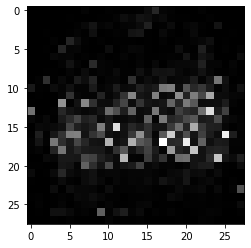

In [20]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()